## 1. Import Libraries & Configuration

In [15]:
from ultralytics import YOLO
import cv2
import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, Video, HTML
import time

# ============================================
# CONFIGURATION
# ============================================

# Đường dẫn model - chọn 1 trong 2:
MODEL_PT = "yolo_industrial_product/yolov11n/weights/best.pt"   # PyTorch model
MODEL_ONNX = "yolo_industrial_product/yolov11n/weights/best.onnx"  # ONNX model

# Chọn model để sử dụng (True = ONNX, False = PyTorch)
USE_ONNX = False

# Ngưỡng confidence và IOU
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.45

# Kích thước ảnh inference
IMG_SIZE = 640

# Folder output
OUTPUT_DIR = "inference_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✅ Configuration loaded")
print(f"   Model: {'ONNX' if USE_ONNX else 'PyTorch'}")
print(f"   Confidence threshold: {CONFIDENCE_THRESHOLD}")
print(f"   IOU threshold: {IOU_THRESHOLD}")
print(f"   Image size: {IMG_SIZE}")

✅ Configuration loaded
   Model: PyTorch
   Confidence threshold: 0.5
   IOU threshold: 0.45
   Image size: 640


In [16]:
# Load model
model_path = MODEL_ONNX if USE_ONNX else MODEL_PT

if os.path.exists(model_path):
    model = YOLO(model_path)
    print(f"✅ Model loaded: {model_path}")
    
    # Hiển thị thông tin model
    if not USE_ONNX:
        model.info()
else:
    print(f"❌ Model không tồn tại: {model_path}")
    print("   Hãy đảm bảo đã copy folder yolo_industrial_product từ training results")

✅ Model loaded: yolo_industrial_product/yolov11n/weights/best.pt
YOLO11n summary: 181 layers, 2,590,035 parameters, 0 gradients, 6.4 GFLOPs


## 2. Helper Functions

In [17]:
def inference_video(video_path, save=True, show_progress=True):
    """
    Inference trên video
    
    Args:
        video_path: Đường dẫn video
        save: Lưu video kết quả
        show_progress: Hiển thị progress
    
    Returns:
        output_path: Đường dẫn video output
    """
    # Kiểm tra video tồn tại
    if not os.path.exists(video_path):
        print(f"❌ Video không tồn tại: {video_path}")
        return None
    
    # Mở video
    cap = cv2.VideoCapture(video_path)
    
    # Lấy thông tin video
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"📹 Video info:")
    print(f"   Resolution: {width}x{height}")
    print(f"   FPS: {fps}")
    print(f"   Total frames: {total_frames}")
    print(f"   Duration: {total_frames/fps:.2f}s")
    
    # Tạo video writer
    output_path = os.path.join(OUTPUT_DIR, f"detected_{Path(video_path).name}")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Process từng frame
    frame_count = 0
    total_detections = 0
    start_time = time.time()
    
    print(f"\n🔄 Processing video...")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Inference
        results = model.predict(
            source=frame,
            conf=CONFIDENCE_THRESHOLD,
            iou=IOU_THRESHOLD,
            imgsz=IMG_SIZE,
            verbose=False
        )
        
        # Vẽ kết quả
        result = results[0]
        frame_with_boxes = result.plot()
        
        # Ghi video
        if save:
            out.write(frame_with_boxes)
        
        frame_count += 1
        total_detections += len(result.boxes)
        
        # Progress
        if show_progress and frame_count % 30 == 0:
            progress = frame_count / total_frames * 100
            elapsed = time.time() - start_time
            eta = (elapsed / frame_count) * (total_frames - frame_count)
            print(f"   Progress: {progress:.1f}% | Frame: {frame_count}/{total_frames} | ETA: {eta:.1f}s")
    
    # Cleanup
    cap.release()
    out.release()
    
    elapsed_time = time.time() - start_time
    avg_fps = frame_count / elapsed_time
    
    print(f"\n✅ Video processing completed!")
    print(f"   Processed {frame_count} frames in {elapsed_time:.2f}s")
    print(f"   Average FPS: {avg_fps:.2f}")
    print(f"   Total detections: {total_detections}")
    print(f"   Average detections/frame: {total_detections/frame_count:.2f}")
    
    if save:
        print(f"💾 Output saved: {output_path}")
    
    return output_path

print("✅ Helper functions loaded")

✅ Helper functions loaded


## 3. Inference trên Video

Chỉ định đường dẫn video và chạy inference

In [20]:
# ============================================
# INFERENCE TRÊN VIDEO
# ============================================

# Chỉ định đường dẫn video
VIDEO_PATH = "video/valHD.mp4"  # <-- Thay đổi đường dẫn video tại đây


if os.path.exists(VIDEO_PATH):
    output_video = inference_video(VIDEO_PATH, save=True, show_progress=True)
else:
    print(f"⚠️ Video không tồn tại: {VIDEO_PATH}")
    print("   Hãy thay đổi VIDEO_PATH thành đường dẫn video hợp lệ")

📹 Video info:
   Resolution: 1280x720
   FPS: 23
   Total frames: 1527
   Duration: 66.39s

🔄 Processing video...
   Progress: 2.0% | Frame: 30/1527 | ETA: 71.8s
   Progress: 3.9% | Frame: 60/1527 | ETA: 70.1s
   Progress: 5.9% | Frame: 90/1527 | ETA: 70.5s
   Progress: 7.9% | Frame: 120/1527 | ETA: 69.4s
   Progress: 9.8% | Frame: 150/1527 | ETA: 67.6s
   Progress: 11.8% | Frame: 180/1527 | ETA: 67.2s
   Progress: 13.8% | Frame: 210/1527 | ETA: 68.2s
   Progress: 15.7% | Frame: 240/1527 | ETA: 66.1s
   Progress: 17.7% | Frame: 270/1527 | ETA: 63.6s
   Progress: 19.6% | Frame: 300/1527 | ETA: 62.0s
   Progress: 21.6% | Frame: 330/1527 | ETA: 60.0s
   Progress: 23.6% | Frame: 360/1527 | ETA: 57.7s
   Progress: 25.5% | Frame: 390/1527 | ETA: 55.9s
   Progress: 27.5% | Frame: 420/1527 | ETA: 53.9s
   Progress: 29.5% | Frame: 450/1527 | ETA: 52.2s
   Progress: 31.4% | Frame: 480/1527 | ETA: 50.4s
   Progress: 33.4% | Frame: 510/1527 | ETA: 48.7s
   Progress: 35.4% | Frame: 540/1527 | ETA: 

## 4. 🎯 Object Counting với Tracking

Đếm số lượng object khi đi qua một vùng/đường định trước sử dụng Ultralytics ObjectCounter.

**Các mode đếm:**
- **Line Counting**: Đếm object khi đi qua một đường thẳng
- **Region Counting**: Đếm object khi vào/ra một vùng polygon

In [25]:
# Cài đặt các dependencies cần thiết cho Object Counting với Tracking
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

# Kiểm tra và cài đặt shapely
try:
    import shapely
    print("✅ shapely đã được cài đặt")
except ImportError:
    print("📦 Đang cài đặt shapely...")
    install_package("shapely>=2.0.0")
    print("✅ shapely đã được cài đặt")

# Kiểm tra và cài đặt lap (Linear Assignment Problem - cần cho tracking)
try:
    import lap
    print("✅ lap đã được cài đặt")
except ImportError:
    print("📦 Đang cài đặt lap...")
    install_package("lapx>=0.5.2")  # lapx là phiên bản thay thế tương thích
    print("✅ lap đã được cài đặt")

print("\n⚠️ Nếu vừa cài đặt packages mới, hãy RESTART KERNEL và chạy lại từ đầu!")
print("=" * 60)

from ultralytics import solutions
from collections import defaultdict

class SequentialIDMapper:
    """
    Lớp để ánh xạ ID tracking gốc sang ID theo thứ tự (1, 2, 3, ...)
    ID mới chỉ được gán khi object đi qua đường đếm
    """
    def __init__(self):
        self.original_to_sequential = {}  # Mapping từ ID gốc -> ID tuần tự
        self.next_sequential_id = 1  # ID tuần tự tiếp theo
        self.counted_ids = set()  # Các ID đã được đếm (đã qua line)
        self.track_history = defaultdict(list)  # Lưu lịch sử vị trí của mỗi track
    
    def get_sequential_id(self, original_id, has_crossed_line=False):
        """
        Lấy ID tuần tự cho một ID gốc
        - Nếu object đã qua line và chưa có ID tuần tự -> gán ID mới
        - Nếu object chưa qua line -> trả về None (không hiển thị ID)
        """
        if original_id in self.original_to_sequential:
            return self.original_to_sequential[original_id]
        
        if has_crossed_line and original_id not in self.counted_ids:
            self.original_to_sequential[original_id] = self.next_sequential_id
            self.counted_ids.add(original_id)
            seq_id = self.next_sequential_id
            self.next_sequential_id += 1
            return seq_id
        
        return None
    
    def check_line_crossing(self, original_id, center_x, center_y, line_points):
        """
        Kiểm tra xem object có vừa đi qua đường đếm không
        Sử dụng lịch sử vị trí để xác định
        """
        self.track_history[original_id].append((center_x, center_y))
        
        # Giữ tối đa 10 vị trí gần nhất
        if len(self.track_history[original_id]) > 10:
            self.track_history[original_id].pop(0)
        
        # Cần ít nhất 2 điểm để kiểm tra crossing
        if len(self.track_history[original_id]) < 2:
            return False
        
        # Lấy 2 vị trí gần nhất
        prev_pos = self.track_history[original_id][-2]
        curr_pos = self.track_history[original_id][-1]
        
        # Kiểm tra crossing dựa trên loại đường
        (x1, y1), (x2, y2) = line_points
        
        # Đường dọc (vertical line): x1 == x2
        if x1 == x2:
            line_x = x1
            # Kiểm tra nếu object di chuyển qua đường dọc
            if (prev_pos[0] < line_x <= curr_pos[0]) or (prev_pos[0] > line_x >= curr_pos[0]):
                return True
        # Đường ngang (horizontal line): y1 == y2
        elif y1 == y2:
            line_y = y1
            # Kiểm tra nếu object di chuyển qua đường ngang
            if (prev_pos[1] < line_y <= curr_pos[1]) or (prev_pos[1] > line_y >= curr_pos[1]):
                return True
        else:
            # Đường xiên: sử dụng công thức tổng quát
            # Tính side của điểm so với đường thẳng
            def side(px, py):
                return (x2 - x1) * (py - y1) - (y2 - y1) * (px - x1)
            
            prev_side = side(prev_pos[0], prev_pos[1])
            curr_side = side(curr_pos[0], curr_pos[1])
            
            # Nếu khác dấu nghĩa là đã cross
            if prev_side * curr_side < 0:
                return True
        
        return False
    
    def assign_id_if_crossed(self, original_id, center_x, center_y, line_points):
        """
        Kiểm tra và gán ID nếu object vừa cross line
        Returns: (sequential_id hoặc None, has_just_crossed)
        """
        # Nếu đã có ID tuần tự rồi, trả về luôn
        if original_id in self.original_to_sequential:
            return self.original_to_sequential[original_id], False
        
        # Kiểm tra có vừa cross không
        has_crossed = self.check_line_crossing(original_id, center_x, center_y, line_points)
        
        if has_crossed:
            seq_id = self.get_sequential_id(original_id, has_crossed_line=True)
            return seq_id, True
        
        return None, False


def inference_video_with_counting(video_path, counting_mode="line", region_points=None, save=True, show_progress=True, line_color=(0, 255, 255), show_id_before_crossing=True):
    """
    Inference trên video với Object Counting khi đi qua vùng/đường định trước
    VỚI ID TUẦN TỰ - ID được gán theo thứ tự khi object qua đường đếm
    
    Args:
        video_path: Đường dẫn video
        counting_mode: "line" hoặc "region"
        region_points: List các điểm định nghĩa đường/vùng đếm
                       - Line: [(x1,y1), (x2,y2)]
                       - Region: [(x1,y1), (x2,y2), (x3,y3), (x4,y4)]
        save: Lưu video kết quả
        show_progress: Hiển thị progress
        line_color: Màu của đường đếm (BGR format). Mặc định: (0, 255, 255) = Vàng
        show_id_before_crossing: Hiển thị ID tracking gốc trước khi qua line (True) 
                                 hoặc chỉ hiển thị ID sau khi qua line (False)
    
    Returns:
        output_path: Đường dẫn video output
        count_results: Kết quả đếm
    """
    # Kiểm tra video tồn tại
    if not os.path.exists(video_path):
        print(f"❌ Video không tồn tại: {video_path}")
        return None, None
    
    # Mở video để lấy thông tin
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    
    print(f"📹 Video info:")
    print(f"   Resolution: {width}x{height}")
    print(f"   FPS: {fps}")
    print(f"   Total frames: {total_frames}")
    print(f"   Duration: {total_frames/fps:.2f}s")
    
    # Định nghĩa vùng đếm mặc định nếu không được cung cấp
    if region_points is None:
        if counting_mode == "line":
            # Đường dọc ở giữa video
            region_points = [(width // 2, 0), (width // 2, height)]
        else:
            # Vùng hình chữ nhật ở giữa video
            margin_x = width // 4
            margin_y = height // 4
            region_points = [
                (margin_x, margin_y),
                (width - margin_x, margin_y),
                (width - margin_x, height - margin_y),
                (margin_x, height - margin_y)
            ]
    
    print(f"\n🎯 Counting mode: {counting_mode.upper()}")
    print(f"   Region points: {region_points}")
    print(f"   ✨ ID Mode: Sequential (ID gán theo thứ tự khi qua line)")
    
    # Tạo output path
    output_path = os.path.join(OUTPUT_DIR, f"counted_{Path(video_path).name}")
    
    # Khởi tạo ID Mapper để gán ID tuần tự
    id_mapper = SequentialIDMapper()
    
    # Mở video để xử lý
    cap = cv2.VideoCapture(video_path)
    
    # Tạo video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Process từng frame
    frame_count = 0
    start_time = time.time()
    in_count = 0
    out_count = 0
    
    print(f"\n🔄 Processing video with sequential ID counting...")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Run YOLO tracking
        results = model.track(
            source=frame,
            conf=CONFIDENCE_THRESHOLD,
            iou=IOU_THRESHOLD,
            imgsz=IMG_SIZE,
            persist=True,  # Giữ tracking qua các frame
            tracker="botsort.yaml",  # Hoặc "bytetrack.yaml"
            verbose=False
        )
        
        result = results[0]
        processed_frame = frame.copy()
        
        # Vẽ đường đếm
        if counting_mode == "line" and len(region_points) == 2:
            pt1 = tuple(region_points[0])
            pt2 = tuple(region_points[1])
            cv2.line(processed_frame, pt1, pt2, line_color, 3)
        
        # Xử lý từng detection
        if result.boxes is not None and len(result.boxes) > 0:
            boxes = result.boxes.xyxy.cpu().numpy()
            
            # Lấy track IDs (nếu có)
            if result.boxes.id is not None:
                track_ids = result.boxes.id.cpu().numpy().astype(int)
            else:
                track_ids = list(range(len(boxes)))
            
            # Lấy confidence và class
            confs = result.boxes.conf.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy().astype(int)
            
            for i, (box, track_id, conf, cls) in enumerate(zip(boxes, track_ids, confs, classes)):
                x1, y1, x2, y2 = map(int, box)
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2
                
                # Kiểm tra và gán ID tuần tự nếu object cross line
                seq_id, just_crossed = id_mapper.assign_id_if_crossed(
                    track_id, center_x, center_y, region_points
                )
                
                # Đếm khi vừa cross
                if just_crossed:
                    # Xác định hướng để đếm IN/OUT
                    # Đơn giản: đếm tất cả là IN (có thể mở rộng logic hướng)
                    in_count += 1
                
                # Vẽ bounding box
                # Màu: Xanh lá nếu đã có ID tuần tự, Vàng nếu chưa
                if seq_id is not None:
                    box_color = (0, 255, 0)  # Xanh lá - đã qua line
                else:
                    box_color = (0, 255, 255)  # Vàng - chưa qua line
                
                cv2.rectangle(processed_frame, (x1, y1), (x2, y2), box_color, 2)
                
                # Vẽ label với ID
                class_name = model.names[cls] if hasattr(model, 'names') else f"cls{cls}"
                
                if seq_id is not None:
                    # Hiển thị ID tuần tự
                    label = f"#{seq_id} {class_name} {conf:.2f}"
                elif show_id_before_crossing:
                    # Hiển thị ID tracking gốc (với prefix 't' để phân biệt)
                    label = f"t{track_id} {class_name} {conf:.2f}"
                else:
                    # Không hiển thị ID trước khi qua line
                    label = f"{class_name} {conf:.2f}"
                
                # Vẽ background cho text
                (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(processed_frame, (x1, y1 - text_h - 10), (x1 + text_w, y1), box_color, -1)
                cv2.putText(processed_frame, label, (x1, y1 - 5), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        # Hiển thị thống kê đếm trên frame
        cv2.putText(processed_frame, f"Counted: {in_count}", (10, 40),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
        cv2.putText(processed_frame, f"Frame: {frame_count}", (10, 80),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        
        # Ghi video
        if save:
            out.write(processed_frame)
        
        frame_count += 1
        
        # Progress
        if show_progress and frame_count % 30 == 0:
            progress = frame_count / total_frames * 100
            elapsed = time.time() - start_time
            eta = (elapsed / frame_count) * (total_frames - frame_count)
            print(f"   Progress: {progress:.1f}% | Frame: {frame_count}/{total_frames} | Counted: {in_count} | ETA: {eta:.1f}s")
    
    # Cleanup
    cap.release()
    out.release()
    
    elapsed_time = time.time() - start_time
    avg_fps = frame_count / elapsed_time
    
    print(f"\n✅ Video processing with sequential counting completed!")
    print(f"   Processed {frame_count} frames in {elapsed_time:.2f}s")
    print(f"   Average FPS: {avg_fps:.2f}")
    print(f"\n📊 COUNTING RESULTS:")
    print(f"   🟢 Total objects counted: {in_count}")
    print(f"   📝 ID range: 1 → {id_mapper.next_sequential_id - 1}")
    
    if save:
        print(f"\n💾 Output saved: {output_path}")
    
    return output_path, {"count": in_count, "id_range": (1, id_mapper.next_sequential_id - 1)}

print("✅ Object Counting function loaded (with Sequential ID)")
print("   - ID được gán theo thứ tự khi object đi qua đường đếm")
print("   - Object 1 qua trước → ID #1, Object 2 qua sau → ID #2, ...")

✅ shapely đã được cài đặt
✅ lap đã được cài đặt

⚠️ Nếu vừa cài đặt packages mới, hãy RESTART KERNEL và chạy lại từ đầu!
✅ Object Counting function loaded (with Sequential ID)
   - ID được gán theo thứ tự khi object đi qua đường đếm
   - Object 1 qua trước → ID #1, Object 2 qua sau → ID #2, ...


### 4.1 Line Counting - Đếm object qua đường thẳng

Đếm object khi đi qua một đường thẳng (ngang hoặc dọc)

In [26]:
# ============================================
# LINE COUNTING - Đếm object qua đường thẳng
# VỚI ID TUẦN TỰ (1, 2, 3, ...)
# ============================================

# Chỉ định đường dẫn video
VIDEO_PATH_COUNT = "video/valHD.mp4"  # <-- Thay đổi đường dẫn video tại đây

# Định nghĩa LINE để đếm (x1, y1) -> (x2, y2)
# Đường DỌC (vertical): thay đổi x, giữ y
# Ví dụ: đường dọc ở vị trí x = 640 (giữa màn hình 1280x720)
LINE_POINTS = [(640, 0), (640, 720)]  # <-- Đường dọc ở x=640, từ top đến bottom

# Định nghĩa màu đường (BGR format - không phải RGB!)
# Vàng: (0, 255, 255)
# Đỏ: (0, 0, 255)
# Xanh: (255, 0, 0)
# Xanh lá: (0, 255, 0)
# Trắng: (255, 255, 255)
LINE_COLOR = (0, 255, 255)  # Vàng

# ============================================
# SEQUENTIAL ID OPTIONS
# ============================================
# True: Hiển thị ID tracking gốc (t1, t3, t10...) TRƯỚC khi qua line
#       Sau khi qua line sẽ chuyển thành ID tuần tự (#1, #2, #3...)
# False: Chỉ hiển thị class name TRƯỚC khi qua line
#        Sau khi qua line mới hiển thị ID tuần tự (#1, #2, #3...)
SHOW_ID_BEFORE_CROSSING = True

# Hoặc để None để sử dụng đường mặc định (giữa video - dọc)
# LINE_POINTS = None

# Các ví dụ khác:
# Đường ngang: LINE_POINTS = [(0, 360), (1280, 360)]  # y = 360 (giữa 720)
# Đường dọc trái: LINE_POINTS = [(320, 0), (320, 720)]  # x = 320 (1/4 bên trái)
# Đường dọc phải: LINE_POINTS = [(960, 0), (960, 720)]  # x = 960 (3/4 bên phải)

if os.path.exists(VIDEO_PATH_COUNT):
    print("🎯 Starting LINE COUNTING mode (SEQUENTIAL ID)...")
    print("   ✨ ID sẽ được gán theo thứ tự: #1, #2, #3, ... khi qua line")
    print()
    output_video, count_results = inference_video_with_counting(
        video_path=VIDEO_PATH_COUNT,
        counting_mode="line",
        region_points=LINE_POINTS,
        save=True,
        show_progress=True,
        line_color=LINE_COLOR,
        show_id_before_crossing=SHOW_ID_BEFORE_CROSSING
    )
else:
    print(f"⚠️ Video không tồn tại: {VIDEO_PATH_COUNT}")
    print("   Hãy thay đổi VIDEO_PATH_COUNT thành đường dẫn video hợp lệ")

🎯 Starting LINE COUNTING mode (SEQUENTIAL ID)...
   ✨ ID sẽ được gán theo thứ tự: #1, #2, #3, ... khi qua line

📹 Video info:
   Resolution: 1280x720
   FPS: 23
   Total frames: 1527
   Duration: 66.39s

🎯 Counting mode: LINE
   Region points: [(640, 0), (640, 720)]
   ✨ ID Mode: Sequential (ID gán theo thứ tự khi qua line)

🔄 Processing video with sequential ID counting...
   Progress: 2.0% | Frame: 30/1527 | Counted: 1 | ETA: 113.7s
   Progress: 2.0% | Frame: 30/1527 | Counted: 1 | ETA: 113.7s
   Progress: 3.9% | Frame: 60/1527 | Counted: 1 | ETA: 108.1s
   Progress: 3.9% | Frame: 60/1527 | Counted: 1 | ETA: 108.1s
   Progress: 5.9% | Frame: 90/1527 | Counted: 2 | ETA: 106.3s
   Progress: 5.9% | Frame: 90/1527 | Counted: 2 | ETA: 106.3s
   Progress: 7.9% | Frame: 120/1527 | Counted: 2 | ETA: 104.7s
   Progress: 7.9% | Frame: 120/1527 | Counted: 2 | ETA: 104.7s
   Progress: 9.8% | Frame: 150/1527 | Counted: 3 | ETA: 106.0s
   Progress: 9.8% | Frame: 150/1527 | Counted: 3 | ETA: 106.0s

### 4.2 Region Counting - Đếm object trong vùng polygon

Đếm object khi vào/ra một vùng hình đa giác

In [11]:
# ============================================
# REGION COUNTING - Đếm object trong vùng polygon
# ============================================

# Chỉ định đường dẫn video
VIDEO_PATH_REGION = "video/valHD.mp4"  # <-- Thay đổi đường dẫn video tại đây

# Định nghĩa REGION (polygon 4 điểm hoặc nhiều hơn)
# Ví dụ: vùng hình chữ nhật
REGION_POINTS = [
    (400, 200),   # Top-left
    (1500, 200),  # Top-right
    (1500, 800),  # Bottom-right
    (400, 800)    # Bottom-left
]  # <-- Thay đổi tọa độ vùng đếm

# Hoặc để None để sử dụng vùng mặc định (giữa video)
# REGION_POINTS = None

if os.path.exists(VIDEO_PATH_REGION):
    print("🎯 Starting REGION COUNTING mode...")
    output_video, count_results = inference_video_with_counting(
        video_path=VIDEO_PATH_REGION,
        counting_mode="region",
        region_points=REGION_POINTS,
        save=True,
        show_progress=True
    )
else:
    print(f"⚠️ Video không tồn tại: {VIDEO_PATH_REGION}")
    print("   Hãy thay đổi VIDEO_PATH_REGION thành đường dẫn video hợp lệ")

🎯 Starting REGION COUNTING mode...
📹 Video info:
   Resolution: 1280x720
   FPS: 23
   Total frames: 1527
   Duration: 66.39s

🎯 Counting mode: REGION
   Region points: [(400, 200), (1500, 200), (1500, 800), (400, 800)]
Ultralytics Solutions:  {'source': None, 'model': 'yolo_industrial_product/yolov11n/weights/best.pt', 'classes': None, 'show_conf': True, 'show_labels': True, 'region': [(400, 200), (1500, 200), (1500, 800), (400, 800)], 'colormap': 21, 'show_in': True, 'show_out': True, 'up_angle': 145.0, 'down_angle': 90, 'kpts': [6, 8, 10], 'analytics_type': 'line', 'figsize': (12.8, 7.2), 'blur_ratio': 0.5, 'vision_point': (20, 20), 'crop_dir': 'cropped-detections', 'json_file': None, 'line_width': 2, 'records': 5, 'fps': 30.0, 'max_hist': 5, 'meter_per_pixel': 0.05, 'max_speed': 120, 'show': False, 'iou': 0.7, 'conf': 0.25, 'device': None, 'max_det': 300, 'half': False, 'tracker': 'botsort.yaml', 'verbose': False, 'data': 'images'}

🔄 Processing video with object counting...
WARNIN

### 4.3 Helper: Xác định tọa độ vùng đếm từ video

Chạy cell này để xem frame đầu tiên của video và xác định tọa độ vùng đếm phù hợp

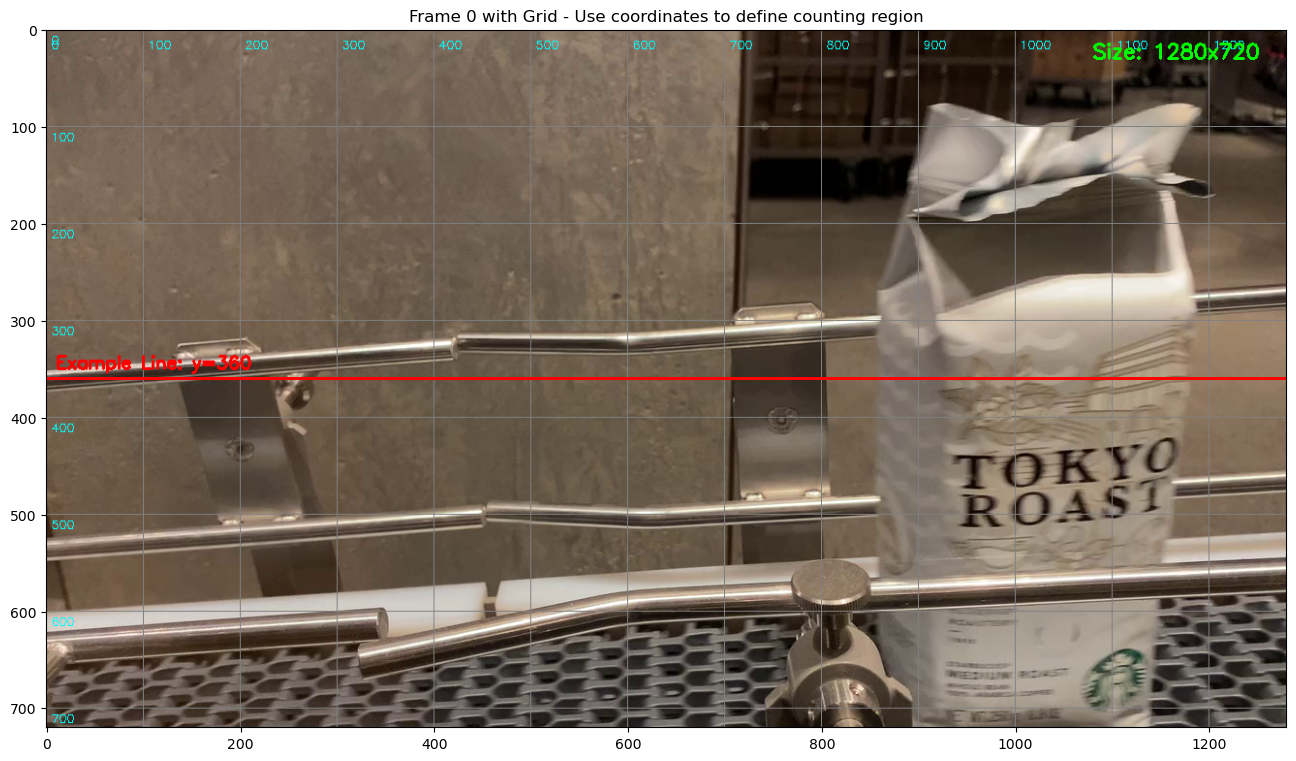


📐 Video dimensions: 1280 x 720
📍 Sử dụng grid để xác định tọa độ cho LINE_POINTS hoặc REGION_POINTS

💡 Ví dụ LINE (đường ngang giữa):
   LINE_POINTS = [(0, 360), (1280, 360)]

💡 Ví dụ REGION (vùng giữa):
   REGION_POINTS = [(320, 180), (960, 180), (960, 540), (320, 540)]


In [12]:
# ============================================
# HELPER: Xem frame và xác định tọa độ
# ============================================

def show_video_frame_with_grid(video_path, frame_number=0):
    """
    Hiển thị frame từ video với grid để dễ xác định tọa độ
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"❌ Không thể đọc frame {frame_number}")
        return
    
    height, width = frame.shape[:2]
    
    # Vẽ grid
    frame_grid = frame.copy()
    
    # Vẽ các đường dọc
    for x in range(0, width, 100):
        cv2.line(frame_grid, (x, 0), (x, height), (128, 128, 128), 1)
        cv2.putText(frame_grid, str(x), (x+5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
    
    # Vẽ các đường ngang
    for y in range(0, height, 100):
        cv2.line(frame_grid, (0, y), (width, y), (128, 128, 128), 1)
        cv2.putText(frame_grid, str(y), (5, y+15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
    
    # Hiển thị thông tin
    cv2.putText(frame_grid, f"Size: {width}x{height}", (width-200, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Vẽ ví dụ line counting (đường ngang giữa)
    mid_y = height // 2
    cv2.line(frame_grid, (0, mid_y), (width, mid_y), (0, 0, 255), 2)
    cv2.putText(frame_grid, f"Example Line: y={mid_y}", (10, mid_y - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    
    # Hiển thị
    plt.figure(figsize=(16, 10))
    plt.imshow(cv2.cvtColor(frame_grid, cv2.COLOR_BGR2RGB))
    plt.title(f'Frame {frame_number} with Grid - Use coordinates to define counting region')
    plt.axis('on')
    plt.show()
    
    print(f"\n📐 Video dimensions: {width} x {height}")
    print(f"📍 Sử dụng grid để xác định tọa độ cho LINE_POINTS hoặc REGION_POINTS")
    print(f"\n💡 Ví dụ LINE (đường ngang giữa):")
    print(f"   LINE_POINTS = [(0, {mid_y}), ({width}, {mid_y})]")
    print(f"\n💡 Ví dụ REGION (vùng giữa):")
    print(f"   REGION_POINTS = [({width//4}, {height//4}), ({3*width//4}, {height//4}), ({3*width//4}, {3*height//4}), ({width//4}, {3*height//4})]")

# Chạy helper
VIDEO_HELPER = "video/valHD.mp4"  # <-- Thay đổi đường dẫn video
if os.path.exists(VIDEO_HELPER):
    show_video_frame_with_grid(VIDEO_HELPER, frame_number=0)
else:
    print(f"⚠️ Video không tồn tại: {VIDEO_HELPER}")

## 5. Webcam Realtime (Tùy chọn)

Inference realtime từ webcam - nhấn 'q' để thoát

In [14]:
# ============================================
# WEBCAM REALTIME INFERENCE
# ============================================
# Chạy cell này để inference từ webcam
# Nhấn 'q' để thoát

def inference_webcam(camera_id=0, save_video=False):
    """
    Inference realtime từ webcam
    
    Args:
        camera_id: ID của camera (0 = webcam mặc định)
        save_video: Lưu video output
    """
    cap = cv2.VideoCapture(camera_id)
    
    if not cap.isOpened():
        print("❌ Không thể mở webcam")
        return
    
    # Lấy thông tin
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30
    
    print(f"📹 Webcam info: {width}x{height} @ {fps}fps")
    print("   Nhấn 'q' để thoát")
    
    # Video writer nếu cần lưu
    out = None
    if save_video:
        output_path = os.path.join(OUTPUT_DIR, "webcam_detection.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # FPS counter
    prev_time = time.time()
    fps_list = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Inference
        results = model.predict(
            source=frame,
            conf=CONFIDENCE_THRESHOLD,
            iou=IOU_THRESHOLD,
            imgsz=IMG_SIZE,
            verbose=False
        )
        
        # Vẽ kết quả
        result = results[0]
        frame_with_boxes = result.plot()
        
        # Tính FPS
        current_time = time.time()
        fps_current = 1 / (current_time - prev_time)
        prev_time = current_time
        fps_list.append(fps_current)
        if len(fps_list) > 30:
            fps_list.pop(0)
        avg_fps = sum(fps_list) / len(fps_list)
        
        # Hiển thị FPS và số objects
        num_objects = len(result.boxes)
        cv2.putText(frame_with_boxes, f"FPS: {avg_fps:.1f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame_with_boxes, f"Objects: {num_objects}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Hiển thị
        cv2.imshow("YOLO Detection - Press 'q' to quit", frame_with_boxes)
        
        # Lưu video
        if save_video and out:
            out.write(frame_with_boxes)
        
        # Thoát khi nhấn 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Cleanup
    cap.release()
    if out:
        out.release()
    cv2.destroyAllWindows()
    
    print("✅ Webcam inference stopped")
    if save_video:
        print(f"💾 Video saved: {output_path}")

# Uncomment dòng dưới để chạy webcam
inference_webcam(camera_id=0, save_video=True)

📹 Webcam info: 640x480 @ 30fps
   Nhấn 'q' để thoát
✅ Webcam inference stopped
💾 Video saved: inference_results\webcam_detection.mp4
✅ Webcam inference stopped
💾 Video saved: inference_results\webcam_detection.mp4


## 6. Quick Inference với YOLO CLI

Sử dụng YOLO CLI để inference nhanh (không cần code)

In [ ]:
# ============================================
# QUICK INFERENCE VỚI YOLO CLI
# ============================================

# Inference trên video
# !yolo predict model=yolo_industrial_product/yolov11n/weights/best.pt source="path/to/video.mp4" conf=0.5

# Inference trên webcam
# !yolo predict model=yolo_industrial_product/yolov11n/weights/best.pt source=0 conf=0.5 show=True

print("📌 Uncomment và chỉnh sửa các lệnh trên để sử dụng YOLO CLI")

## 📝 Tóm tắt

### Cách sử dụng:
1. **Load model**: Cell 2-3 - tự động load model từ `best.pt` hoặc `best.onnx`
2. **Video inference cơ bản**: Cell 6 - inference đơn giản không đếm
3. **🎯 Object Counting với Tracking**:
   - Cell 8: Hàm counting chính
   - Cell 10: **Line Counting** - đếm object qua đường thẳng
   - Cell 12: **Region Counting** - đếm object trong vùng polygon
   - Cell 14: **Helper** - xem frame với grid để xác định tọa độ
4. **Webcam**: Cell 16 - uncomment dòng cuối và chạy
5. **CLI**: Cell 18 - uncomment lệnh và chạy

### Output:
- Tất cả kết quả được lưu trong folder `inference_results/`
- Video thường: `detected_<tên_file>.mp4`
- Video counting: `counted_<tên_file>.mp4`
- Webcam: `webcam_detection.mp4`

### 🎯 Object Counting Features:
- **Line Counting**: Đếm IN/OUT khi object đi qua đường thẳng
- **Region Counting**: Đếm IN/OUT khi object vào/ra vùng polygon
- **Tracking**: Sử dụng BoT-SORT tracker để theo dõi object
- **Real-time display**: Hiển thị số đếm trên video

### Tips:
- Sử dụng **Helper cell** để xác định tọa độ vùng đếm chính xác
- Đường đếm nên đặt vuông góc với hướng di chuyển của object
- Với video dài, kiểm tra GPU memory để tránh OOM
- Điều chỉnh `CONFIDENCE_THRESHOLD` nếu có quá nhiều false positives